In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import grad, jit, vmap, random
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from scipy.linalg import toeplitz
import pandas as pd
from scipy import sparse

In [ ]:
case = 0
SAMPLE_INDEX = 0

# key_noise_train, key_noise_test = random.split(random.PRNGKey(2))
key_noise_train = random.PRNGKey(case)
key_noise_test = random.PRNGKey(case)

Net_work_key = 100
# ## 1. Loading data by pandas
# Neural network models
num_train = 10000
num_test = 500

test_input_file_name = 'Test_Observations' + str(num_test)
test_output_file_name = 'Test_PoI_samples_d' + str(num_test)

df_test_Observations = pd.read_csv('NS_equation/data/' + test_input_file_name + '.csv')
df_test_Parameters = pd.read_csv('NS_equation/data/' + test_output_file_name + '.csv')

test_Observations_synthetic = np.reshape(df_test_Observations.to_numpy(), (num_test, -1))
test_Parameters = np.reshape(df_test_Parameters.to_numpy(), (num_test, -1))

# ### 1.1 Add noise
noise_level = 0.01
# train_Observations = train_Observations_synthetic + noise_level * (random.normal(key_noise_train, shape=train_Observations_synthetic.shape)) * jnp.reshape(jnp.max(train_Observations_synthetic, axis=1), (num_train, 1))
test_Observations = test_Observations_synthetic + noise_level * (random.normal(key_noise_test, shape=test_Observations_synthetic.shape)) * jnp.reshape(jnp.max(test_Observations_synthetic, axis=1), (num_test, 1))

# Extract single sample
single_test_observation = test_Observations[SAMPLE_INDEX, :]
single_test_parameter = test_Parameters[SAMPLE_INDEX, :]

# ### 1.2 Load Basis functions and observation locations

# Physical model information
n = 32
dimension_of_PoI = (n)**2  # external force field
num_observation = 20  # number of observed points
num_truncated_series = 24

df_Basis = pd.read_csv('NS_equation/data/Basis' + '.csv')
df_obs_locations = pd.read_csv('NS_equation/data/obs_locations' + '.csv')

Basis = np.reshape(df_Basis.to_numpy(), (dimension_of_PoI, num_truncated_series))
obs_locations = np.reshape(df_obs_locations.to_numpy(), (num_observation))

Basis = jax.numpy.asarray(Basis)
obs_locations = jax.numpy.asarray(obs_locations)

# ## 2 - Spectral method for 2D Navier-Stokes equation
# initialize parameters
N = n

# steps size
dx = 1 / N
dy = 1 / N

x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)

visc = 1e-3
T_end = 10.0
delta_t = 1e-2 * 5

# Maximum frequency
k_max = jnp.floor(N/2.0)

# Number of steps to final time
steps = jnp.ceil(T_end/delta_t).astype(int)

# force source
f = 0.1*(jnp.sin(2*jnp.pi*(X + Y)) + jnp.cos(2*jnp.pi*(X + Y)))

# Forcing to Fourier space
f_h = jnp.fft.fft2(f)

# Wavenumbers in y-direction
k = jnp.concatenate((jnp.arange(0, k_max, 1, dtype=int), jnp.arange(-k_max, 0, 1, dtype=int)))
k_y = jnp.tile(k, (32, 1))

# Wavenumbers in x-direction
k_x = k_y.T

# Negative Laplacian in Fourier space
lap = 4*(np.pi**2)*(k_x**2 + k_y**2)
lap = lap.at[0, 0].set(1.0)

# Dealiasing mask
dealias = jnp.logical_and(jnp.abs(k_y) < 2. / 3. * k_max, jnp.abs(k_x) < 2. / 3. * k_max) * 1

@jit
def body_loop(i, w_h):
    # Stream function in Fourier space: solve Poisson equation
    psi_h_real = jnp.real(w_h)/lap
    psi_h_imag = jnp.imag(w_h)/lap
    
    # Velocity field in x-direction = psi_y
    q_real, q_imag = psi_h_real, psi_h_imag
    temp = q_real
    
    q_real = -2 * jnp.pi * k_y * q_imag
    q_imag = 2 * jnp.pi * k_y * temp
    q = jnp.real(jnp.fft.ifft2(q_real + q_imag * 1j))
    
    # Velocity field in y-direction = -psi_x
    v_real, v_imag = psi_h_real, psi_h_imag
    temp = v_real
    
    v_real = 2 * jnp.pi * k_x * v_imag
    v_imag = -2 * jnp.pi * k_x * temp
    v = jnp.real(jnp.fft.ifft2(v_real + v_imag * 1j))
    
    # Partial x of vorticity
    w_x_real, w_x_imag = jnp.real(w_h), jnp.imag(w_h)
    temp = w_x_real
    w_x_real = -2 * jnp.pi * k_x * w_x_imag
    w_x_imag = 2 * jnp.pi * k_x * temp
    w_x = jnp.real(jnp.fft.ifft2(w_x_real + w_x_imag * 1j))
    
    # Partial y of vorticity
    w_y_real, w_y_imag = jnp.real(w_h), jnp.imag(w_h)
    temp = w_y_real
    w_y_real = -2 * jnp.pi * k_y * w_y_imag
    w_y_imag = 2 * jnp.pi * k_y * temp
    w_y = jnp.real(jnp.fft.ifft2(w_y_real + w_y_imag * 1j))
    
    # Non-linear term (u.grad(w)): compute in physical space then back to Fourier space
    F_h = jnp.fft.fft2(q*w_x + v*w_y)
    
    # Dealias
    F_h = dealias * F_h
    
    # Cranck-Nicholson update
    w_h = (-delta_t*F_h + delta_t*f_h + (1.0 - 0.5*delta_t*visc*lap)*w_h)/(1.0 + 0.5*delta_t*visc*lap)

    return w_h

# Forward operator
def forward_op(x):
    # ==================== for each sample ================== #
    w0 = jnp.asarray(jnp.reshape((Basis @ x.T), (N, N)))

    # Initial vorticity to Fourier space
    w_h = jnp.fft.fft2(w0)
    
    w_h = jax.lax.fori_loop(0, steps, body_loop, (w_h))
    
    # Transform back to physical space
    w = jnp.real(jnp.fft.ifft2(w_h))
    
    out_pred = (w.flatten())[[obs_locations],]
    return out_pred.flatten()

In [4]:
test_Observations_synthetic[0,]

array([-0.90741955, -0.94195318, -0.50931209,  0.80724212, -0.30986628,
       -0.95339057, -0.35444984,  0.77755486, -0.36214565,  0.15859928,
       -0.79232055, -0.03856121,  0.87253669, -0.37540537, -0.33352484,
        0.80734072, -1.06493824, -0.04191955, -0.95208001, -1.02930918])

In [5]:
forward_op(single_test_parameter)

Array([-0.90741955, -0.94195318, -0.50931209,  0.80724212, -0.30986628,
       -0.95339057, -0.35444984,  0.77755486, -0.36214565,  0.15859928,
       -0.79232055, -0.03856121,  0.87253669, -0.37540537, -0.33352484,
        0.80734072, -1.06493824, -0.04191955, -0.95208001, -1.02930918],      dtype=float64)

In [12]:
inverted_params = np.load('NS_equation/Single_Sample_0_Best_Summary_case_0_Noise_0.01_inverse_solution.npy')


Text(0.5, 1.0, 'Inverted Parameters vs Ground Truth')

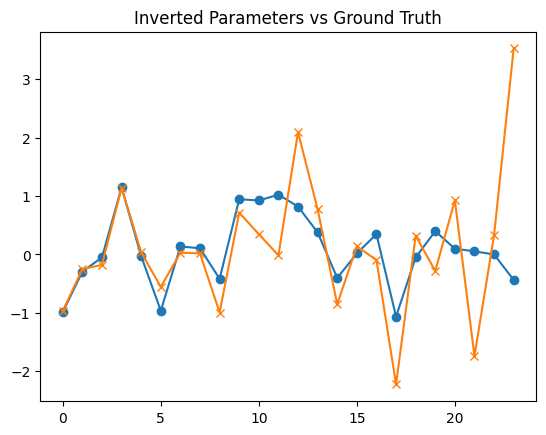

In [13]:
plt.plot(inverted_params, label='Inverted Parameters', marker='o')
plt.plot(single_test_parameter, label='Ground Truth', marker='x')
plt.title('Inverted Parameters vs Ground Truth')

# Bayesian framework

Single Sample Navier-Stokes Bayesian Inverse Problem with HMC
Alpha = 1000 (Fixed)
Navier-Stokes Bayesian Analysis Setup:
  Sample index: 0
  Parameter dimension: 24
  Observation dimension: 20
  Regularization α: 4.83e-01
  Noise level: 1.0%
  Observation std: 0.014391
  Time steps: 200

Running HMC sampling...
Starting warmup...
Warmup 100/200, accept_prob: 1.000, avg_accept: 0.999, epsilon: 0.00265
Warmup 200/200, accept_prob: 0.994, avg_accept: 0.998, epsilon: 0.00308
Adapted mass matrix from 99 warmup samples
Final warmup epsilon: 0.00308
Starting sampling...
Sample 50/1000, Accept rate: 1.000
Sample 100/1000, Accept rate: 1.000
Sample 150/1000, Accept rate: 1.000
Sample 200/1000, Accept rate: 1.000
Sample 250/1000, Accept rate: 1.000
Sample 300/1000, Accept rate: 1.000
Sample 350/1000, Accept rate: 1.000
Sample 400/1000, Accept rate: 1.000
Sample 450/1000, Accept rate: 0.998
Sample 500/1000, Accept rate: 0.998
Sample 550/1000, Accept rate: 0.998
Sample 600/1000, Accept rate: 0.99

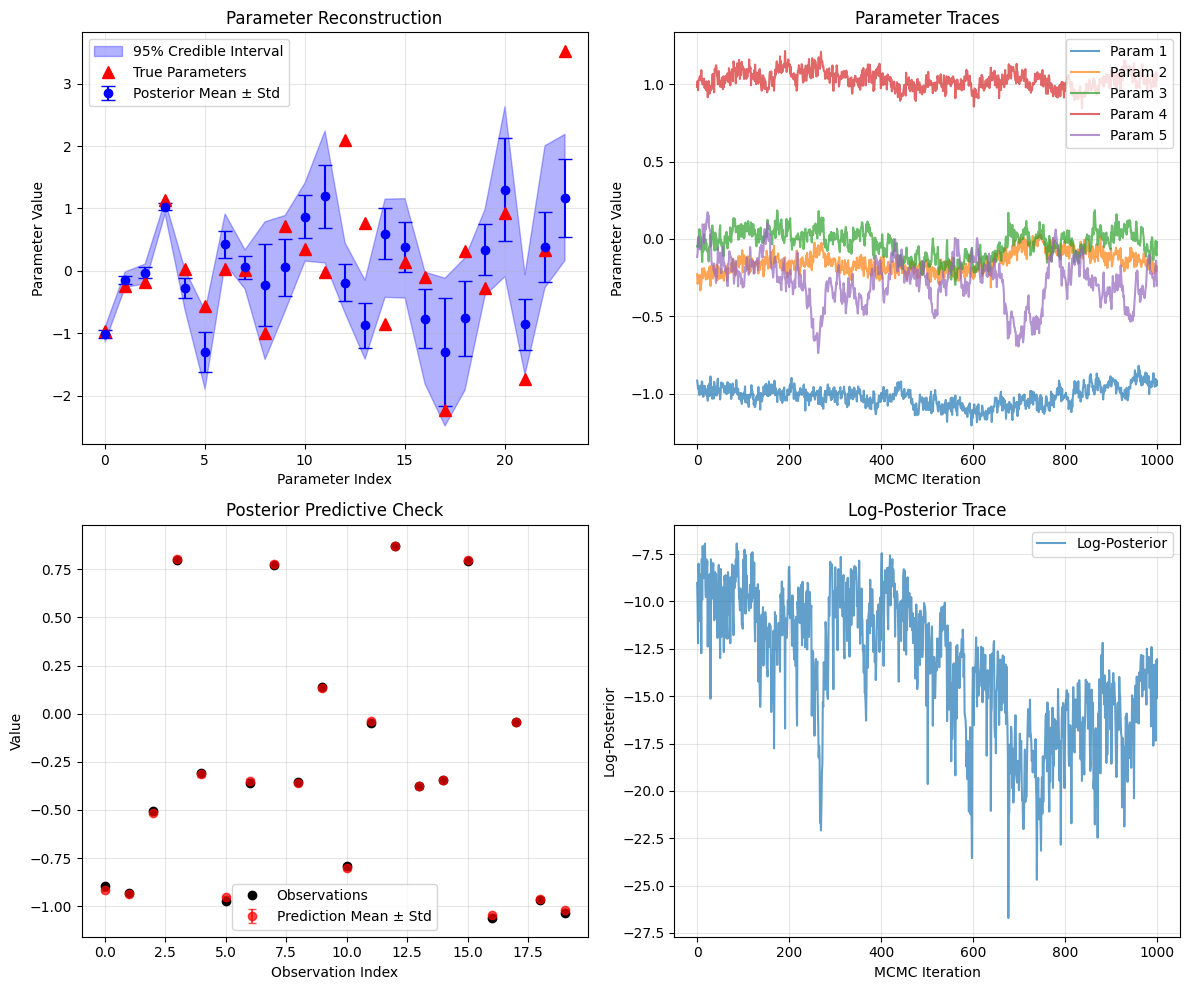


Results saved to: ns_bayesian_single_sample_0_alpha_5e-01.npy

Navier-Stokes Bayesian analysis complete!


In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random, lax
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import pandas as pd

# Set JAX to use double precision for better numerical accuracy
jax.config.update("jax_enable_x64", True)

class JAXHMCBayesianInverse:
    """
    HMC sampler for general Bayesian inverse problems using JAX
    Handles nonlinear forward operators without analytical solutions
    """
    
    def __init__(self, forward_operator, y_obs, sigma, prior_mean, prior_cov_inv, initial_x):
        """
        Parameters:
        -----------
        forward_operator : callable
            Nonlinear forward operator function: x -> G(x)
        y_obs : array
            Observed data
        sigma : float or array
            Observation noise standard deviation
        prior_mean : array
            Prior mean
        prior_cov_inv : array
            Prior precision matrix (inverse covariance)
        initial_x : array
            Initial parameter guess
        """
        # Convert to JAX arrays
        self.y_obs = jnp.array(y_obs)
        self.sigma = jnp.array(sigma) if np.isscalar(sigma) else jnp.array(sigma)
        self.prior_mean = jnp.array(prior_mean)
        self.prior_cov_inv = jnp.array(prior_cov_inv)
        self.x_init = jnp.array(initial_x)
        
        # Store forward operator
        self.forward_operator = jit(forward_operator)
        
        # HMC parameters
        self.epsilon = 0.001  # Smaller step size for NS equation
        self.n_leapfrog = 15  # Fewer leapfrog steps due to computational cost
        self.mass_matrix = jnp.eye(len(initial_x))
        
        # Compile functions
        self._compile_functions()
    
    def _compile_functions(self):
        """Compile JAX functions for efficiency"""
        
        @jit
        def log_likelihood(x):
            """Compute log-likelihood for potentially nonlinear forward operator"""
            predictions = self.forward_operator(x)
            residual = predictions - self.y_obs
            
            # Handle both scalar and vector sigma
            if jnp.isscalar(self.sigma):
                return -0.5 * jnp.sum(residual**2) / self.sigma**2
            else:
                # Diagonal covariance case
                return -0.5 * jnp.sum((residual / self.sigma)**2)
        
        @jit
        def log_prior(x):
            """Compute log-prior using mean and precision matrix"""
            x_centered = x - self.prior_mean
            return -0.5 * jnp.dot(x_centered, self.prior_cov_inv @ x_centered)
        
        @jit
        def log_posterior(x):
            """Compute log-posterior"""
            return log_likelihood(x) + log_prior(x)
        
        # Store compiled functions
        self.log_posterior_fn = log_posterior
        self.log_likelihood_fn = log_likelihood
        self.log_prior_fn = log_prior
        self.grad_log_posterior_fn = jit(grad(log_posterior))
        
        # Combined function for efficiency
        @jit
        def log_posterior_and_grad(x):
            return log_posterior(x), grad(log_posterior)(x)
        
        self.log_posterior_and_grad_fn = log_posterior_and_grad
    
    @partial(jit, static_argnums=(0,))
    def leapfrog_step(self, x, momentum, epsilon):
        """Single leapfrog integration step"""
        
        # Half step for momentum
        _, grad_x = self.log_posterior_and_grad_fn(x)
        momentum = momentum + 0.5 * epsilon * grad_x
        
        # Full step for position
        mass_inv = jnp.linalg.solve(self.mass_matrix, momentum)
        x = x + epsilon * mass_inv
        
        # Half step for momentum
        _, grad_x = self.log_posterior_and_grad_fn(x)
        momentum = momentum + 0.5 * epsilon * grad_x
        
        return x, momentum
    
    @partial(jit, static_argnums=(0,))
    def compute_energy(self, x, momentum):
        """Compute Hamiltonian energy"""
        log_p = self.log_posterior_fn(x)
        kinetic = 0.5 * jnp.dot(momentum, jnp.linalg.solve(self.mass_matrix, momentum))
        return -log_p + kinetic
    
    def hmc_step(self, x_current, key):
        """Complete HMC step"""
        
        # Sample momentum
        key, subkey = random.split(key)
        momentum = random.normal(subkey, shape=x_current.shape)
        
        # Current energy
        energy_current = self.compute_energy(x_current, momentum)
        
        # Leapfrog trajectory
        x_prop = x_current
        momentum_prop = momentum
        
        for _ in range(self.n_leapfrog):
            x_prop, momentum_prop = self.leapfrog_step(
                x_prop, momentum_prop, self.epsilon
            )
        
        # Negate momentum for reversibility
        momentum_prop = -momentum_prop
        
        # Proposed energy
        energy_prop = self.compute_energy(x_prop, momentum_prop)
        
        # Accept/reject
        delta_energy = energy_prop - energy_current
        accept_prob = jnp.minimum(1.0, jnp.exp(-delta_energy))
        
        key, subkey = random.split(key)
        accept = random.uniform(subkey) < accept_prob
        
        x_new = jnp.where(accept, x_prop, x_current)
        
        return x_new, accept, accept_prob, energy_current, key
    
    def sample(self, n_samples, n_warmup=500, seed=42, target_accept=0.65, adapt_mass_matrix=True):
        """
        Run HMC sampling with adaptation
        """
        
        key = random.PRNGKey(seed)
        x = self.x_init.copy()
        
        # Storage
        samples = []
        accept_rates = []
        energies = []
        log_posteriors = []
        
        print("Starting warmup...")
        warmup_samples = []
        step_sizes = []
        
        # Warmup phase with step size adaptation
        for i in range(n_warmup):
            x, accepted, accept_prob, energy, key = self.hmc_step(x, key)
            
            # Store for mass matrix adaptation
            if i > n_warmup // 2 and adapt_mass_matrix:
                warmup_samples.append(x)
            
            # Dual averaging for step size adaptation
            if i < n_warmup - 50:  # Stop adaptation earlier
                eta = 1.0 / (i + 10)  # Adaptation rate
                self.epsilon *= jnp.exp(eta * (accept_prob - target_accept))
                self.epsilon = jnp.clip(self.epsilon, 1e-6, 0.1)  # Tighter bounds for NS
            
            step_sizes.append(self.epsilon)
            
            if (i + 1) % 100 == 0:
                recent_accepts = accept_rates[-100:] if len(accept_rates) >= 100 else accept_rates
                avg_accept = np.mean(recent_accepts) if recent_accepts else accept_prob
                print(f"Warmup {i+1}/{n_warmup}, "
                      f"accept_prob: {accept_prob:.3f}, "
                      f"avg_accept: {avg_accept:.3f}, "
                      f"epsilon: {self.epsilon:.5f}")
            
            accept_rates.append(accept_prob)
        
        # Adapt mass matrix from warmup samples
        if len(warmup_samples) > 50 and adapt_mass_matrix:
            warmup_array = jnp.array(warmup_samples)
            sample_cov = jnp.cov(warmup_array.T)
            # Add regularization
            regularization = 1e-5 * jnp.eye(sample_cov.shape[0])
            self.mass_matrix = sample_cov + regularization
            print(f"Adapted mass matrix from {len(warmup_samples)} warmup samples")
        
        print(f"Final warmup epsilon: {self.epsilon:.5f}")
        print("Starting sampling...")
        
        # Reset counters for sampling phase
        accept_rates = []
        total_accepted = 0
        
        # Sampling phase
        for i in range(n_samples):
            x, accepted, accept_prob, energy, key = self.hmc_step(x, key)
            
            samples.append(x)
            accept_rates.append(accept_prob)
            energies.append(energy)
            log_posteriors.append(self.log_posterior_fn(x))
            total_accepted += accepted
            
            if (i + 1) % 50 == 0:  # More frequent updates
                current_accept_rate = total_accepted / (i + 1)
                print(f"Sample {i+1}/{n_samples}, "
                      f"Accept rate: {current_accept_rate:.3f}")
        
        samples = jnp.array(samples)
        
        # Diagnostics
        diagnostics = {
            'accept_rate': total_accepted / n_samples,
            'accept_probs': jnp.array(accept_rates),
            'energies': jnp.array(energies),
            'log_posteriors': jnp.array(log_posteriors),
            'final_epsilon': self.epsilon,
            'final_mass_matrix': self.mass_matrix,
            'step_sizes_warmup': step_sizes
        }
        
        return samples, diagnostics
    
    def posterior_predictive(self, samples, n_pred=None):
        """Generate posterior predictive samples"""
        if n_pred is None:
            n_pred = min(50, len(samples))  # Limit for computational efficiency
        
        # Select random subset of samples
        key = random.PRNGKey(0)
        indices = random.choice(key, len(samples), shape=(n_pred,), replace=True)
        selected_samples = samples[indices]
        
        # Vectorized forward operator
        predictions = vmap(self.forward_operator)(selected_samples)
        
        return predictions


def effective_sample_size(samples):
    """Compute effective sample size for each parameter"""
    from scipy import signal
    
    def ess_single_chain(x):
        """ESS for a single chain"""
        n = len(x)
        x = x - np.mean(x)
        
        # Auto-correlation function
        autocorr = signal.correlate(x, x, mode='full')
        autocorr = autocorr[n-1:]
        autocorr = autocorr / autocorr[0]
        
        # Find first negative autocorrelation
        first_negative = np.where(autocorr < 0)[0]
        if len(first_negative) > 0:
            cutoff = first_negative[0]
        else:
            cutoff = len(autocorr)
        
        # Sum autocorrelations up to cutoff
        sum_autocorr = 2 * np.sum(autocorr[1:cutoff]) + 1
        
        return n / sum_autocorr if sum_autocorr > 0 else n
    
    # Compute ESS for each parameter
    ess_values = []
    for i in range(samples.shape[1]):
        ess_values.append(ess_single_chain(samples[:, i]))
    
    return np.array(ess_values)


def plot_simple_results(samples, true_params, y_obs, diagnostics, pred_samples):
    """Simple plotting for single sample analysis"""
    
    # Compute sample statistics
    samples_mean = np.mean(samples, axis=0)
    samples_std = np.std(samples, axis=0)
    samples_q025 = np.percentile(samples, 2.5, axis=0)
    samples_q975 = np.percentile(samples, 97.5, axis=0)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Parameter reconstruction
    ax = axes[0, 0]
    param_indices = np.arange(len(true_params))
    
    ax.errorbar(param_indices, samples_mean, yerr=samples_std, 
                fmt='bo', capsize=5, label='Posterior Mean ± Std')
    ax.fill_between(param_indices, samples_q025, samples_q975, 
                    alpha=0.3, color='blue', label='95% Credible Interval')
    ax.plot(param_indices, true_params, 'r^', markersize=8, label='True Parameters')
    
    ax.set_xlabel('Parameter Index')
    ax.set_ylabel('Parameter Value')
    ax.set_title('Parameter Reconstruction')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Parameter traces (first 5 parameters)
    ax = axes[0, 1]
    n_trace = min(5, samples.shape[1])
    for i in range(n_trace):
        ax.plot(samples[:, i], alpha=0.7, label=f'Param {i+1}')
    ax.set_xlabel('MCMC Iteration')
    ax.set_ylabel('Parameter Value')
    ax.set_title('Parameter Traces')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Posterior predictive check
    ax = axes[1, 0]
    if pred_samples is not None:
        pred_mean = np.mean(pred_samples, axis=0)
        pred_std = np.std(pred_samples, axis=0)
        obs_indices = np.arange(len(y_obs))
        
        ax.errorbar(obs_indices, pred_mean, yerr=pred_std, 
                    fmt='ro', capsize=3, alpha=0.7, label='Prediction Mean ± Std')
        ax.plot(obs_indices, y_obs, 'ko', markersize=6, label='Observations')
        
        ax.set_xlabel('Observation Index')
        ax.set_ylabel('Value')
        ax.set_title('Posterior Predictive Check')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Diagnostics
    ax = axes[1, 1]
    ax.plot(diagnostics['log_posteriors'], alpha=0.7, label='Log-Posterior')
    ax.set_xlabel('MCMC Iteration')
    ax.set_ylabel('Log-Posterior')
    ax.set_title('Log-Posterior Trace')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def run_single_sample_ns_bayesian_analysis():
    """
    Run Bayesian analysis for single sample with Navier-Stokes equation
    Uses fixed alpha = 1000
    """
    
    # Your NS data loading code
    case = 0
    SAMPLE_INDEX = 0

    # Random keys
    key_noise_train = random.PRNGKey(case)
    key_noise_test = random.PRNGKey(case)

    # Data parameters
    num_train = 10000
    num_test = 500

    # File names
    test_input_file_name = 'Test_Observations' + str(num_test)
    test_output_file_name = 'Test_PoI_samples_d' + str(num_test)

    # Load data
    df_test_Observations = pd.read_csv('NS_equation/data/' + test_input_file_name + '.csv')
    df_test_Parameters = pd.read_csv('NS_equation/data/' + test_output_file_name + '.csv')

    test_Observations_synthetic = np.reshape(df_test_Observations.to_numpy(), (num_test, -1))
    test_Parameters = np.reshape(df_test_Parameters.to_numpy(), (num_test, -1))

    # Add noise
    noise_level = 0.01
    test_Observations = test_Observations_synthetic + noise_level * (random.normal(key_noise_test, shape=test_Observations_synthetic.shape)) * jnp.reshape(jnp.max(test_Observations_synthetic, axis=1), (num_test, 1))

    # Extract single sample
    single_test_observation = test_Observations[SAMPLE_INDEX, :]
    single_test_parameter = test_Parameters[SAMPLE_INDEX, :]

    # Physical model information
    n = 32
    dimension_of_PoI = (n)**2
    num_observation = 20
    num_truncated_series = 24

    # Load basis and observation locations
    df_Basis = pd.read_csv('NS_equation/data/Basis.csv')
    df_obs_locations = pd.read_csv('NS_equation/data/obs_locations.csv')

    Basis = np.reshape(df_Basis.to_numpy(), (dimension_of_PoI, num_truncated_series))
    obs_locations = np.reshape(df_obs_locations.to_numpy(), (num_observation))

    Basis = jax.numpy.asarray(Basis)
    obs_locations = jax.numpy.asarray(obs_locations)

    # Navier-Stokes solver setup
    N = n
    dx = 1 / N
    dy = 1 / N

    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y)

    visc = 1e-3
    T_end = 10.0
    delta_t = 1e-2 * 5

    k_max = jnp.floor(N/2.0)
    steps = jnp.ceil(T_end/delta_t).astype(int)

    f = 0.1*(jnp.sin(2*jnp.pi*(X + Y)) + jnp.cos(2*jnp.pi*(X + Y)))
    f_h = jnp.fft.fft2(f)

    k = jnp.concatenate((jnp.arange(0, k_max, 1, dtype=int), jnp.arange(-k_max, 0, 1, dtype=int)))
    k_y = jnp.tile(k, (32, 1))
    k_x = k_y.T

    lap = 4*(np.pi**2)*(k_x**2 + k_y**2)
    lap = lap.at[0, 0].set(1.0)

    dealias = jnp.logical_and(jnp.abs(k_y) < 2. / 3. * k_max, jnp.abs(k_x) < 2. / 3. * k_max) * 1

    @jit
    def body_loop(i, w_h):
        # Stream function in Fourier space: solve Poisson equation
        psi_h_real = jnp.real(w_h)/lap
        psi_h_imag = jnp.imag(w_h)/lap
        
        # Velocity field in x-direction = psi_y
        q_real, q_imag = psi_h_real, psi_h_imag
        temp = q_real
        
        q_real = -2 * jnp.pi * k_y * q_imag
        q_imag = 2 * jnp.pi * k_y * temp
        q = jnp.real(jnp.fft.ifft2(q_real + q_imag * 1j))
        
        # Velocity field in y-direction = -psi_x
        v_real, v_imag = psi_h_real, psi_h_imag
        temp = v_real
        
        v_real = 2 * jnp.pi * k_x * v_imag
        v_imag = -2 * jnp.pi * k_x * temp
        v = jnp.real(jnp.fft.ifft2(v_real + v_imag * 1j))
        
        # Partial x of vorticity
        w_x_real, w_x_imag = jnp.real(w_h), jnp.imag(w_h)
        temp = w_x_real
        w_x_real = -2 * jnp.pi * k_x * w_x_imag
        w_x_imag = 2 * jnp.pi * k_x * temp
        w_x = jnp.real(jnp.fft.ifft2(w_x_real + w_x_imag * 1j))
        
        # Partial y of vorticity
        w_y_real, w_y_imag = jnp.real(w_h), jnp.imag(w_h)
        temp = w_y_real
        w_y_real = -2 * jnp.pi * k_y * w_y_imag
        w_y_imag = 2 * jnp.pi * k_y * temp
        w_y = jnp.real(jnp.fft.ifft2(w_y_real + w_y_imag * 1j))
        
        # Non-linear term (u.grad(w)): compute in physical space then back to Fourier space
        F_h = jnp.fft.fft2(q*w_x + v*w_y)
        
        # Dealias
        F_h = dealias * F_h
        
        # Cranck-Nicholson update
        w_h = (-delta_t*F_h + delta_t*f_h + (1.0 - 0.5*delta_t*visc*lap)*w_h)/(1.0 + 0.5*delta_t*visc*lap)

        return w_h

    # Forward operator for NS equation
    @jit
    def forward_op(x):
        w0 = jnp.asarray(jnp.reshape((Basis @ x.T), (N, N)))
        w_h = jnp.fft.fft2(w0)
        w_h = jax.lax.fori_loop(0, steps, body_loop, (w_h))
        w = jnp.real(jnp.fft.ifft2(w_h))
        out_pred = (w.flatten())[[obs_locations],]
        return out_pred.flatten()

    # Setup Bayesian analysis
    sigma_obs = noise_level * np.max(np.abs(test_Observations_synthetic))
    alpha = 1/10000 / sigma_obs**2  # Fixed regularization parameter
    
    print(f"Navier-Stokes Bayesian Analysis Setup:")
    print(f"  Sample index: {SAMPLE_INDEX}")
    print(f"  Parameter dimension: {num_truncated_series}")
    print(f"  Observation dimension: {len(single_test_observation)}")
    print(f"  Regularization α: {alpha:.2e}")
    print(f"  Noise level: {noise_level*100:.1f}%")
    print(f"  Observation std: {sigma_obs:.6f}")
    print(f"  Time steps: {steps}")
    
    # Prior setup
    prior_mean = jnp.zeros(num_truncated_series)
    prior_cov_inv = alpha * jnp.eye(num_truncated_series)
    
    # Initialize HMC sampler
    sampler = JAXHMCBayesianInverse(
        forward_operator=forward_op,
        y_obs=single_test_observation,
        sigma=sigma_obs,
        prior_mean=prior_mean,
        prior_cov_inv=prior_cov_inv,
        initial_x=prior_mean
    )
    
    # Run HMC sampling with reduced parameters for NS
    print("\nRunning HMC sampling...")
    samples, diagnostics = sampler.sample(
        n_samples=1000,  # Reduced for computational efficiency
        n_warmup=200,    # Reduced warmup
        seed=42,
        target_accept=0.6,  # Slightly lower target
        adapt_mass_matrix=True
    )
    
    # Print results
    print(f"\nSampling completed!")
    print(f"Final acceptance rate: {diagnostics['accept_rate']:.3f}")
    print(f"Final step size: {diagnostics['final_epsilon']:.5f}")
    
    # Compute posterior statistics
    samples_mean = np.mean(samples, axis=0)
    samples_std = np.std(samples, axis=0)
    
    print(f"\nPosterior summary:")
    print(f"Truth:      {single_test_parameter}")
    print(f"Post mean:  {samples_mean}")
    print(f"Post std:   {samples_std}")
    
    # Compute reconstruction error
    reconstruction_error = np.sqrt(np.mean((samples_mean - single_test_parameter)**2))
    relative_error = reconstruction_error / np.sqrt(np.mean(single_test_parameter**2))
    print(f"\nReconstruction error:")
    print(f"  RMSE: {reconstruction_error:.6f}")
    print(f"  Relative RMSE: {relative_error:.6f}")
    
    # Compute effective sample size
    ess = effective_sample_size(samples)
    print(f"\nEffective sample size:")
    print(f"  Mean ESS: {np.mean(ess):.1f}")
    print(f"  Min ESS:  {np.min(ess):.1f}")
    print(f"  ESS/N ratio: {np.mean(ess)/len(samples):.3f}")
    
    # Generate posterior predictive samples (reduced number)
    print("\nGenerating posterior predictive samples...")
    pred_samples = sampler.posterior_predictive(samples, n_pred=30)
    
    # Plot results
    plot_simple_results(samples, single_test_parameter, single_test_observation, diagnostics, pred_samples)
    
    # Save results
    results_data = {
        'samples': samples,
        'true_parameters': single_test_parameter,
        'observations': single_test_observation,
        'posterior_mean': samples_mean,
        'posterior_std': samples_std,
        'reconstruction_rmse': reconstruction_error,
        'relative_rmse': relative_error,
        'acceptance_rate': float(diagnostics['accept_rate']),
        'effective_sample_sizes': ess,
        'alpha': alpha,
        'sample_index': SAMPLE_INDEX
    }
    
    # Save as numpy files
    np.save(f'ns_bayesian_single_sample_{SAMPLE_INDEX}_alpha_{alpha:.0e}.npy', results_data)
    print(f"\nResults saved to: ns_bayesian_single_sample_{SAMPLE_INDEX}_alpha_{alpha:.0e}.npy")
    
    return samples, diagnostics, sampler, results_data


if __name__ == "__main__":
    print("Single Sample Navier-Stokes Bayesian Inverse Problem with HMC")
    print("Alpha = 1000 (Fixed)")
    print("="*60)
    
    samples, diagnostics, sampler, results = run_single_sample_ns_bayesian_analysis()
    
    print("\nNavier-Stokes Bayesian analysis complete!")

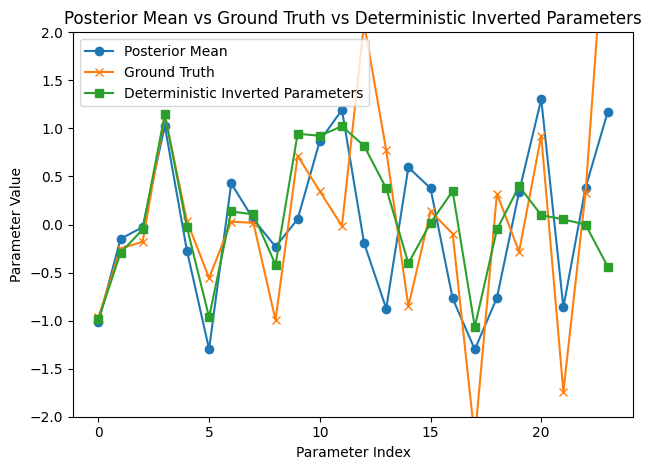

In [35]:
samples_mean = np.mean(samples, axis=0)
plt.plot(samples_mean, label='Posterior Mean', marker='o')
plt.plot(single_test_parameter, label='Ground Truth', marker='x')
plt.plot(inverted_params, label='Deterministic Inverted Parameters', marker='s')
plt.title('Posterior Mean vs Ground Truth vs Deterministic Inverted Parameters')
plt.xlabel('Parameter Index')
plt.ylabel('Parameter Value')
plt.legend()
plt.tight_layout()
plt.ylim(-2,2)
# plt.grid()
plt.show()

In [27]:
from matplotlib import cm  # Colour map
N = 32
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)
XX = X.flatten()
YY = Y.flatten()

def plot_domain(nodal_values, top, bottom, de, filename = '', save = False, cmap = cm.Reds):
    L = np.sort(np.asarray((list(set(np.round(np.linspace(bottom, top, 30),3))))))
    fig = plt.figure()
    fig.patch.set_facecolor('xkcd:white')
    ax = fig.add_subplot(1,1,1)
    surf = ax.contourf(X, Y, (np.reshape(nodal_values, (32,32))), vmin = bottom, vmax = top, cmap=cmap, levels = L)
    cbar = fig.colorbar(surf, shrink = 1., orientation = 'vertical', pad = 0.02)
    cbar.set_ticks(np.linspace(bottom, top, de))
    
    for point in obs_locations:
        plt.plot(XX[point,], YY[point,], 'ks', mew=3, ms=1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])
    
    if save:
        plt.savefig(filename, bbox_inches='tight')
        plt.close()
    else:
        plt.show()



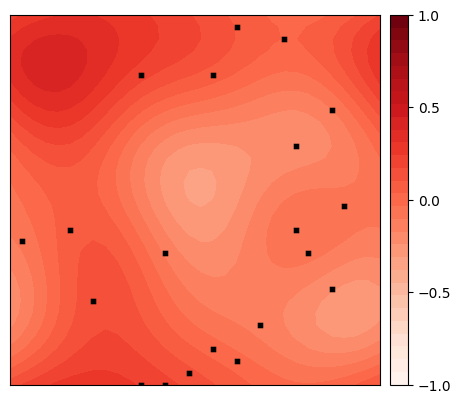

In [28]:
true_PoI = np.einsum('bi, ji -> bj', inverted_params[None,], Basis)
nodal_values = true_PoI

plot_domain(nodal_values, 1, -1, 5)


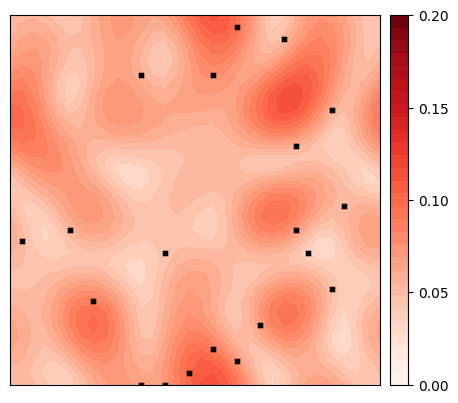

In [33]:

# standard deviation of the samples
true_PoI = np.einsum('bi, ji -> bj', samples, Basis)
nodal_values = np.std(true_PoI, axis=0)
max, min, de = .2, 0, 0.02

plot_domain(nodal_values, max, min, 5)